# 1. 前準備 (csvの読み込みと紐づけ)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #seabornない人はpip installしてね
import os
from datetime import datetime
import numpy as np
from pathlib import Path

# カレントディレクトリを.pyと合わせるために以下を実行
if Path.cwd().name == "notebook":
    os.chdir("..")

# 設定
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_columns', 500)

# 浮動小数点数を小数点以下3桁で表示するように設定
pd.set_option('display.float_format', '{:.3f}'.format)

In [2]:
# Mac Matplotlibのデフォルトフォントをヒラギノ角ゴシックに設定
plt.rcParams['font.family'] = 'Hiragino Sans'

In [3]:
# Windows MatplotlibのデフォルトフォントをMeiryoに設定
plt.rcParams['font.family'] = 'Meiryo'

In [4]:
# point_history.csvの読み込み
file_path_point_history = 'data/input/point_history_cleansing.csv'
df_point_history = pd.read_csv(file_path_point_history)

df_point_history = df_point_history.drop(columns=['total_amount'])    # 'total_amount'は全部N

C:\Users\yu_ta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# user_info.csvの読み込み
file_path_user_info = 'data/input/user_info_cleansing.csv'
df_user_info = pd.read_csv(file_path_user_info)

In [6]:
# user_infoにageとage_groupのカラムを追加
# ageの算出・追加
df_user_info['birth_day'] = pd.to_datetime(df_user_info['birth_day'], errors='coerce')    # birth_dayをdatetimeに変換
current_year = pd.Timestamp.now().year
df_user_info['age'] = current_year - df_user_info['birth_day'].dt.year

# 年代の算出・追加
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
df_user_info['age_group'] = pd.cut(df_user_info['age'], bins=bins, labels=labels, right=False)

In [7]:
# point_history.csvとuser_info.csvをmerge (左内部結合)
df_merge = pd.merge(df_point_history, df_user_info, left_on='user_id', right_on='id', how='left')

In [8]:
# マージしたコードの確認
# display(df_merge.head(100))
# df_merge["total_amount"].unique()
display(df_merge.describe())
# #print(len(df_merge["user_uid"].unique()))
# #print(df_merge.info(verbose=True, show_counts=True))
# print(df_merge['nickname'].isna().sum())

,Unnamed: 0_x,id_x,user_id,series_id,shop_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,coin,rank_id,支店ID,store_latitude,store_longitude,Unnamed: 0_y,id_y,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,zipcode,age
count,2149728.000,2149728.000,2149728.000,1295685.000,1253882.000,1253884.000,1253888.000,1253884.000,2105409.000,1253883.000,2149728.000,2149724.000,2147086.000,1248489.000,1243893.000,1243893.000,2085787.000,2085787.000,2085787.000,2085787.000,2085787.000,2085787.000,2085787.000,2085787.000,1961478.000,2085372.000
mean,1085361.322,11863325.458,42111.151,8.435,669.300,1.003,9.121,9.101,1.661,26.813,3.259,34.433,0.755,166.241,37.695,140.475,49288.296,41365.151,1659.628,21.386,410.640,241.543,6.155,0.533,7385623.443,55.541
std,623743.634,3891833.683,32727.141,2.022,1612.244,0.102,9.678,9.654,12.884,91.546,2.810,322.394,1.101,116.977,0.931,0.418,29558.598,32319.339,2818.910,76.267,895.382,622.669,21.814,0.985,3179784.574,11.287
min,0.000,22.000,1.000,1.000,9.000,1.000,0.000,0.000,0.000,0.000,1.000,-20000.000,0.000,3.000,35.853,139.081,3.000,62.000,0.000,0.000,0.000,0.000,0.000,0.000,1000006.000,7.000
25%,546351.750,9691203.500,11074.000,9.000,305.000,1.000,4.000,4.000,0.000,0.000,1.000,1.000,0.000,73.000,36.918,140.142,22379.000,10927.000,281.000,0.000,103.000,73.000,0.000,0.000,3210932.000,48.000
50%,1086521.500,12993836.500,35809.000,9.000,772.000,1.000,7.000,7.000,0.000,0.000,1.000,6.000,0.000,151.000,37.803,140.448,48000.000,34790.000,861.000,0.000,218.000,140.000,0.000,0.000,9638041.000,56.000
75%,1625353.250,14890424.250,72672.000,9.000,986.000,1.000,11.000,11.000,0.000,0.000,7.000,16.000,1.000,232.000,38.294,140.872,76605.000,70894.000,2068.000,0.000,417.000,225.000,0.000,1.000,9820031.000,63.000
max,2164431.000,16576491.000,105518.000,20.000,1239999.000,4.000,503.000,503.000,2200.000,4216.000,7.000,15000.000,3.000,530.000,39.712,141.367,99819.000,105512.000,59900.000,3614.000,16880.000,15460.000,149.700,5.000,9999999.000,103.000


# 2. 分析

## 2-1. rankごとの平均年間持込量kgの算出

・rank_id毎のrecycle_amount_per_year平均の算出  
・rankが高いほど、年間持ち込み量が多いという仮説を証明する(当然？)  
・rank_idは、0:ブロンズ、1:シルバー、2:ゴールド、3:プラチナ  
・1か月に15kg持ち込み続けるとランクUP。ランクダウンは不明(1か月15kgを達成しないとダウン説、、？)  
※以下の手順を踏むと「rank毎の1回の持ち込み量平均」になってしまうので注意  
　　① amount_kgは1回の持ち込み量。これをrank_id毎にsumする  
　　② rank_idそれぞれの出現回数をsumする  
　　③ ①を②で割る  

In [9]:
# まずそれぞれのカラムの基本統計量を確認しておく
print('recycle_amount_per_year')
print(df_merge['recycle_amount_per_year'].describe())
print('------------------')
print('rank_id')
print(df_merge['rank_id'].describe())
print('------------------')
print('rank_idのユニーク')
print(df_merge['rank_id'].unique())

recycle_amount_per_year
count   2085787.000
mean        241.543
std         622.669
min           0.000
25%          73.000
50%         140.000
75%         225.000
max       15460.000
Name: recycle_amount_per_year, dtype: float64
------------------
rank_id
count   2147086.000
mean          0.755
std           1.101
min           0.000
25%           0.000
50%           0.000
75%           1.000
max           3.000
Name: rank_id, dtype: float64
------------------
rank_idのユニーク
[ 0.  2.  1.  3. nan]


※rankは3（プラチナ）が不在な点に注意

In [10]:
# user_idの重複行を削除（非効率だと思いつつ、、、）
df_merge_duplicates_user_id = df_merge.drop_duplicates(subset='user_id')

ランク毎の持ち込みamountの平均 = df_merge.groupby('rank_id')['recycle_amount_per_year'].mean()
ランク毎の持ち込みamountの平均

rank_id
0.000   125.483
1.000   287.655
2.000   290.110
3.000   680.981
Name: recycle_amount_per_year, dtype: float64

### 得られた示唆

・ランクが高いほど、平均年間持ち込み量は多い  
　→「持ち込み量が多いから、ランクが上がった」という解釈の方が正しい？  
 ・rankのカラムのみ、user_infoに紐づけておくと、user_infoの情報量が増えてよいかも


## 2-2. ユーザ個人に着目して指針を得る 

### 2-2-1. トップユーザのamount_kg推移

・point、coin、rankが、ユーザの持ち込み量に影響を与えているのか確認  
・rankを維持したい人


In [11]:
# 'user_id'の各値の出現回数を計算
user_id_counts = df_merge['user_id'].value_counts().reset_index()
user_id_counts.columns = ['user_id', 'count']

# 元のDataFrameにcountをマージ
df_merge = df_merge.merge(user_id_counts, on='user_id')

# 出現回数に基づいてソート（降順）
df_merge = df_merge.sort_values(by='count', ascending=False)

In [12]:
# 重複を削除して、上位100名のcountをtableで俯瞰する
df_merged_duplicates_user_id = df_merge.drop_duplicates(subset='user_id')
top_100 = df_merged_duplicates_user_id.head(100)
top_100

,Unnamed: 0_x,id_x,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude,Unnamed: 0_y,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode,age,age_group,count
727277,877594,12011006,27133,10.000,326.000,みやぎ生協大河原店,3150100225982,1.000,1.000,1.000,2.000,89.000,1,6.000,3.000,2023-05-04 11:38:27,2023-05-05 04:04:18,2023-05-05 04:04:18,339.000,みやぎ生協,大河原店,326,2022-04-23 03:15:28,2023-03-31 20:40:44,09:00:00,21:30:00,09:00:00,19:00:00,38.049,140.731,23464.000,27133.000,春,2282.000,129.000,2896.000,2060.000,0.000,0.000,女,1950-11-29,9891245.000,73.000,71-80,3127
34257,1558776,14657714,1152,3.000,11.000,ビフレ東通店,315bifre074937,1.000,0.000,0.000,1.000,142.000,1,0.000,3.000,2023-09-09 15:13:36,2023-09-10 04:00:19,2023-09-10 04:00:19,4.000,ビフレ,東通店,11,2021-09-21 04:02:39,2023-04-07 16:15:20,09:30:00,22:00:00,09:30:00,20:30:00,39.712,140.142,7122.000,1152.000,畠山寿子,21800.000,113.000,3410.000,807.500,0.000,0.000,女,1947-01-06,NaN,76.000,71-80,2071
1430569,1097110,13044986,38423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,3,0.000,0.000,2023-06-27 12:22:59,2023-06-27 12:22:59,2023-06-27 12:22:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35194.000,38423.000,FITS開発者,705.000,10.000,10.000,10.000,0.000,0.000,男,1994-01-01,9800811.000,29.000,21-30,2027
38049,279391,7042287,912,3.000,168.000,ビフレ新庄店,315bifre056848,1.000,0.000,0.000,1.000,92.000,1,0.000,0.000,2022-08-10 19:53:47,2022-08-11 04:00:21,2022-08-11 04:00:21,7.000,ビフレ,新庄店,168,2021-09-21 04:12:05,2023-04-07 16:24:30,09:00:00,20:50:00,09:00:00,20:00:00,38.760,140.289,90117.000,912.000,ハルヤマサンポ,317.000,21.000,305.200,100.750,0.000,1.000,男,1948-03-30,9960027.000,75.000,71-80,2003
1061304,1922680,15828773,37378,9.000,NaN,NaN,7600001477764093,NaN,NaN,NaN,NaN,NaN,4,-500.000,3.000,2023-11-01 09:02:23,2023-11-01 09:02:23,2023-11-01 09:02:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34111.000,37378.000,Gue,11350.000,0.000,10040.000,7252.000,0.000,0.000,女,1976-10-05,9810964.000,47.000,41-50,1764
881438,1136109,13196472,24467,9.000,1194.000,NaN,7600005574265474,1.000,6.000,6.000,0.000,0.000,1,36.000,3.000,2023-07-03 11:48:25,2023-07-05 00:07:11,2023-07-05 00:07:11,399.000,ヨークベニマル,鹿沼千渡店,ITOYOKADO0001194,2022-06-24 13:53:29,2023-03-31 20:40:44,09:30:00,21:30:00,09:30:00,20:00:00,36.567,139.778,20695.000,24467.000,ことにーにー,2230.000,0.000,11420.000,9170.000,0.000,0.000,男,1970-07-24,3220025.000,53.000,51-60,1670
391143,1361350,13986736,8130,9.000,132.000,NaN,7600090538362922,1.000,6.000,6.000,0.000,0.000,1,36.000,3.000,2023-08-08 20:15:04,2023-08-10 00:21:51,2023-08-10 00:21:51,138.000,ヨークベニマル,泉が丘店,ITOYOKADO0000132,2021-09-22 00:59:13,2023-04-08 15:08:35,09:30:00,21:45:00,09:30:00,21:00:00,36.568,139.919,79632.000,8130.000,ポイントゲッター,33180.000,0.000,7144.000,6916.000,0.000,0.000,男,1963-03-07,3210951.000,60.000,61-70,1196
44256,117691,3415216,1083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,3,5000.000,3.000,2022-02-01 11:33:43,2022-02-01 11:33:43,2022-02-01 11:33:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6366.000,1083.000,オバラ,361.000,80.000,2920.000,898.000,0.000,0.000,女,1963-06-26,NaN,60.000,61-70,1173
31522,48836,1438443,1593,3.000,11.000,ビフレ東通店,315bifre016209,1.000,0.000,0.000,1.000,149.000,1,0.000,0.000,2021-06-22 10:02:11,2021-06-23 02:00:52,2021-06-23 02:00:52,4.000,ビフレ,東通店,11,2021-09-21 04:02:39,2023-04-07 16:15:20,09:30:00,22:00:00,09:30:00,20:30:00,39.712,140.142,11832.000,1593.000,sakura,2208.000,98.000,543.000,185.500,0.000,0.000,女,1977-12-17,NaN,46.000,41-50,1172
910457,616755,10310482,27451,9.000,NaN,NaN,7600000824961709,NaN,NaN,NaN,NaN,NaN,4,-500.000,3.000,2023-02-07 00:00:44,2023-02-07 00:00:44,2023-02-07 00:00:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

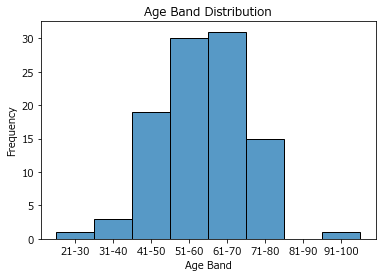

In [13]:
# top_100の年代別人数を表示
sns.histplot(data=top_100, x='age_group')

plt.title('Age Band Distribution')
plt.xlabel('Age Band')
plt.ylabel('Frequency')

plt.show()

In [14]:
# # 特定の人のamount_kgの推移を確認
# # 特定の人のデータのみ抽出
# target_user_id = 1152
# df_merge_target = df_merge[df_merge['user_id'] == target_user_id]
# df_merge_target = df_merge_target.sort_values(by='use_date', ascending=True)

# df_merge_target['use_date'] = pd.to_datetime(df_merge_target['use_date'])

# # use_dateを月ごとに集約（データ数が多すぎて折れ線グラフが見づらい）
# df_merge_target_monthly = df_merge_target[['use_date', 'amount_kg']].resample('M', on='use_date').sum()

# # 集約されたデータで折れ線グラフを作成
# plt.figure(figsize=(10, 6))
# plt.plot(df_merge_target_monthly.index, df_merge_target_monthly['amount_kg'], marker='o')
# plt.title('Monthly Average of Amount (kg)')
# plt.xlabel('Month')
# plt.ylabel('Average Amount (kg)')

# # データをすべて使って折れ線グラフを作成
# plt.figure(figsize=(10, 6))
# plt.plot(df_merge_target_monthly['use_date'], df_merge_target_monthly['rank_id'], marker='o')
# plt.title('rank')
# plt.xlabel('date')
# plt.ylabel('rank')
# plt.show()

# # coinが付与され始めた時期のデータを表示
# filtered_df  = df_merge_target[df_merge_target['coin'] > 0]
# filtered_df.head()


### まとめ

・15kgを達成しても、すぐにランクが上がらない矛盾あり  
・15kgを未達でもすぐにランクが下がらない矛盾あり  
・アプリを利用していなくても履歴は残る。アプリを利用しているか否かは'coin'(付与コイン)で判断する  

## 2-3. rankシステムの効果測定

・rank_idのレコード

In [15]:
# TODO: amount_kgの平均を出してしまっているので、user　rank_idごとのamount_kgの合計を出さないといけない？？
# Calculate the average recycling amount for each user and each rank
avg_amount_per_user_rank = df_merge.groupby(['user_id', 'rank_id'])['amount_kg'].mean().reset_index()
# avg_amount_per_user_rank = df_merge.groupby(['user_id', 'rank_id'])['amount_kg'].sum().reset_index()

# To compare the average recycling amount of different ranks for each user, we need to pivot the data
pivot_table = avg_amount_per_user_rank.pivot(index='user_id', columns='rank_id', values='amount_kg')

# Calculate the difference between each rank's average recycling amount for each user
# For simplicity, we'll calculate the difference between consecutive ranks (rank N and rank N-1)
rank_differences = pivot_table.diff(axis=1)

In [16]:
rank_differences.head(100)

rank_id,0.000,1.000,2.000,3.000
user_id,,,,
1,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN
61,NaN,3.400,NaN,NaN
62,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN
65,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN
67,NaN,-0.771,0.440,NaN
69,NaN,NaN,NaN,NaN


## 1,2,3ごとの平均値を出してみる

In [17]:
average_difference_rank = rank_differences.mean(skipna=True)
average_difference_rank

rank_id
0.000      NaN
1.000   -0.943
2.000   -0.478
3.000   -0.740
dtype: float64

## 1,2,3ごとの合計を出してみる

In [18]:
# TODO: amount_kgの平均を出してしまっているので、user　rank_idごとのamount_kgの合計を出さないといけない？？
# Calculate the average recycling amount for each user and each rank
sum_amount_per_user_rank = df_merge.groupby(['user_id', 'rank_id'])['amount_kg'].sum().reset_index()
# avg_amount_per_user_rank = df_merge.groupby(['user_id', 'rank_id'])['amount_kg'].sum().reset_index()

# To compare the average recycling amount of different ranks for each user, we need to pivot the data
pivot_table = sum_amount_per_user_rank.pivot(index='user_id', columns='rank_id', values='amount_kg')

# Calculate the difference between each rank's average recycling amount for each user
# For simplicity, we'll calculate the difference between consecutive ranks (rank N and rank N-1)
rank_differences = pivot_table.diff(axis=1)

In [19]:
sum_difference_rank = rank_differences.mean(skipna=True)
sum_difference_rank

rank_id
0.000       NaN
1.000   -70.898
2.000     1.826
3.000    87.899
dtype: float64

## 2-3. 店舗ごとのポイント・コイン・リサイクル量・営業時間の可視化

### 2-3-1. スーパーの名前を一覧

In [21]:
df_merge["super"].unique()

array(['みやぎ生協 ', nan, 'ヨークベニマル', 'ビフレ', 'コープふくしま ', 'プロマート',
       'フレッシュフードモリヤ', 'スーパービッグ', 'ザ・ビッグエクストラ', 'マルホンカウボーイ', 'イオンモール',
       'サン・マルシェ', 'サンマリ', 'ドン・キホーテ', 'ザ・ビッグ', 'マックスバリュ', 'ヨークフーズ',
       '清水フードセンター', 'イオン'], dtype=object)

### 2-3-2. 店舗ごとのポイント・コイン・リサイクル量

#### 示唆
持込量が圧倒的に多いのはヨークベニマル。ただしヨークベニマルはリサイクルポイントシステムを導入していない。(というのがどういうことなのか確認)
持込量・獲得ポイントの平均値はどのスーパーでも大差なし。獲得コインはやや差がある様に見えるが、意味があるかは不明。

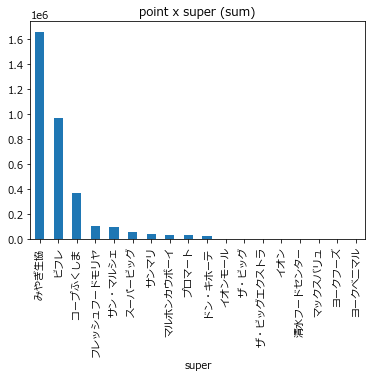

In [25]:
df_merge_super_ptsum = df_merge.groupby('super')['point'].sum().sort_values(ascending=False)
df_merge_super_ptsum.plot(kind='bar')
plt.title('point x super (sum)')
plt.show()

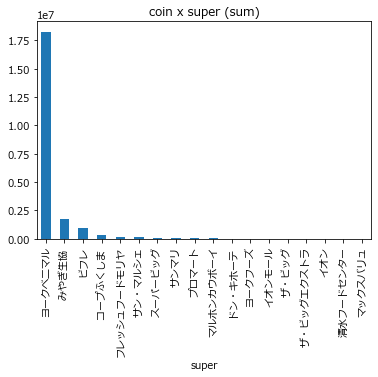

In [26]:
df_merge_super_ptsum = df_merge.groupby('super')['coin'].sum().sort_values(ascending=False)
df_merge_super_ptsum.plot(kind='bar')
plt.title('coin x super (sum)')
plt.show()

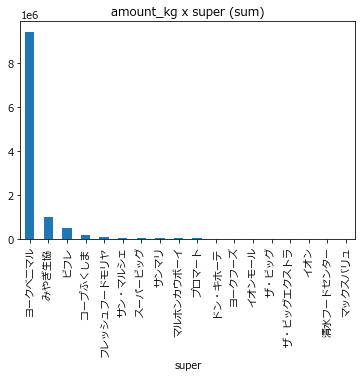

In [27]:
df_merge_super_kgsum = df_merge.groupby('super')['amount_kg'].sum().sort_values(ascending=False)
df_merge_super_kgsum.plot(kind='bar')
plt.title('amount_kg x super (sum)')
plt.show()

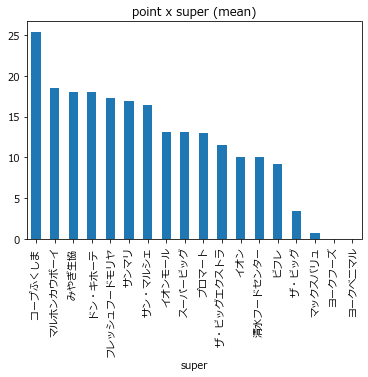

In [30]:
df_merge_super_ptmean = df_merge.groupby('super')['point'].mean().sort_values(ascending=False)
df_merge_super_ptmean.plot(kind='bar')
plt.title('point x super (mean)')
plt.show()

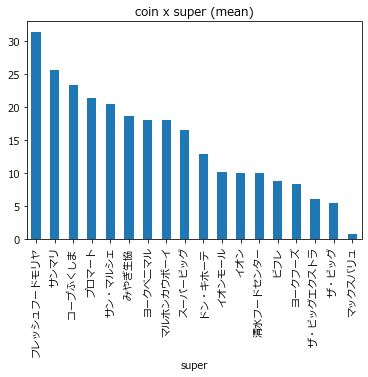

In [31]:
df_merge_super_ptmean = df_merge.groupby('super')['coin'].mean().sort_values(ascending=False)
df_merge_super_ptmean.plot(kind='bar')
plt.title('coin x super (mean)')
plt.show()

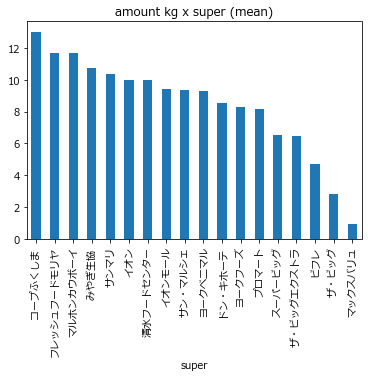

In [32]:
df_merge_super_kgmean = df_merge.groupby('super')['amount_kg'].mean().sort_values(ascending=False)
df_merge_super_kgmean.plot(kind='bar')
plt.title('amount kg x super (mean)')
plt.show()

### 2-3-3. 店舗 x 年代ごとの持込量合計(または平均)のクロス集計

In [35]:
df_merge_pivot_sum = df_merge.pivot_table(index='super', columns='age_group', values='amount_kg', aggfunc='sum')
df_merge_pivot_sum

age_group,0-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100
super,,,,,,,,,
みやぎ生協,728.000,8847.650,38901.950,128272.330,252324.890,318206.980,197283.310,29461.240,451.000
イオン,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
イオンモール,0.000,59.150,151.150,289.750,120.650,83.650,0.000,0.000,0.000
コープふくしま,386.090,1166.260,7211.440,22334.780,52004.280,59620.720,32357.680,5400.610,4105.730
サンマリ,0.000,498.750,1951.940,4075.740,7661.520,3482.260,3875.100,0.000,0.000
サン・マルシェ,0.000,1251.370,5440.070,16927.360,17056.750,11191.860,3993.170,0.000,0.000
ザ・ビッグ,0.000,1.000,3.500,14.500,5.850,0.750,0.000,0.000,0.000
ザ・ビッグエクストラ,0.000,12.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000
スーパービッグ,0.000,356.760,1863.790,5566.410,10836.650,5068.990,1140.250,501.290,0.000


In [36]:
df_merge_pivot_mean = df_merge.pivot_table(index='super', columns='age_group', values='amount_kg', aggfunc='mean')
df_merge_pivot_mean

age_group,0-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-100
super,,,,,,,,,
みやぎ生協,7.663,10.031,9.500,10.437,10.791,11.536,9.825,11.747,14.094
イオンモール,NaN,14.787,7.557,14.488,8.043,6.435,NaN,NaN,NaN
コープふくしま,14.850,10.900,9.514,11.633,13.311,13.584,14.069,12.707,16.827
サンマリ,NaN,6.650,7.685,10.451,10.270,10.682,17.614,NaN,NaN
サン・マルシェ,NaN,8.571,6.834,8.080,9.534,12.864,16.569,NaN,NaN
ザ・ビッグ,NaN,1.000,1.750,7.250,2.925,0.750,NaN,NaN,NaN
ザ・ビッグエクストラ,NaN,12.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
スーパービッグ,NaN,5.170,4.344,6.362,7.312,5.632,14.434,8.643,NaN
ドン・キホーテ,10.950,6.000,6.896,7.924,8.884,9.279,10.758,NaN,NaN


### 2-3-4. 店舗ごとの店舗営業時間およびRPS稼働時間の可視化

### 示唆
#### 開店時間は9:00-9:30が多い。RPSも同様。
#### 閉店時間は21:00-22:00が多い。RPSは19時に閉まる店舗が多い。
#### RPSは9:00-19:00の稼働が多いが、店舗が長く営業していると、それに合わせてやや長く設定している。
#### 店舗営業時間に対するRPS稼働時間は、ほぼ100%の塊と、80%程度の塊が多い。 

In [38]:
# 各列をdatetime型に変換する関数
def convert_to_datetime(df, column):
    df[column] = pd.to_datetime(df[column], format='%H:%M:%S', errors='coerce').dt.time

df_converted = df_merge.copy()
columns_to_convert = ['store_opening_time', 'store_closing_time', 'rps_opening_time', 'rps_closing_time']
for column in columns_to_convert:
    convert_to_datetime(df_converted, column)

In [40]:
#分析に使用する列の追加((1)店舗営業時間、(2)RPS稼働時間、(3)店舗営業時間におけるRPS稼働時間の割合(2)/(1))
# 時間の差分を計算する関数
import datetime
def calculate_time_difference(time1, time2):
    if pd.isnull(time1) or pd.isnull(time2):
        return pd.NaT
    return datetime.datetime.combine(datetime.date.min, time2) - datetime.datetime.combine(datetime.date.min, time1)

df_converted['shop_business_hours'] = df_converted.apply(lambda row: calculate_time_difference(row['store_opening_time'], row['store_closing_time']), axis=1)
df_converted['rps_operating_hours'] = df_converted.apply(lambda row: calculate_time_difference(row['rps_opening_time'], row['rps_closing_time']), axis=1)
df_converted['rps_shop_hour_ratio'] = df_converted.apply(lambda row: row['rps_operating_hours'] / row['shop_business_hours'] if row['shop_business_hours'] != datetime.timedelta(0) else pd.NaT, axis=1)

print(df_converted.head())

        Unnamed: 0_x      id_x  user_id  series_id  shop_id  shop_name  \
727277        877594  12011006    27133     10.000  326.000  みやぎ生協大河原店   
726552        580761  10009624    27133     10.000  326.000  みやぎ生協大河原店   
726554        580763  10009626    27133     10.000  326.000  みやぎ生協大河原店   
726555        580764  10009627    27133     10.000  326.000  みやぎ生協大河原店   
726556        580765  10009628    27133     10.000  326.000  みやぎ生協大河原店   

              card_id  リサイクル分類ID  amount  amount_kg  point  total_point  \
727277  3150100225982      1.000   1.000      1.000  2.000       89.000   
726552  3150100225982      1.000   0.000      0.000  0.000       55.000   
726554  3150100225982      1.000   0.000      0.000  0.000       55.000   
726555  3150100225982      1.000   1.000      1.000  2.000       55.000   
726556  3150100225982      1.000   0.000      0.000  0.000       55.000   

        status  coin  rank_id             use_date           created_at  \
727277       1 6.000    3.000

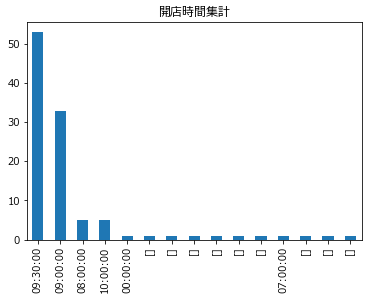

In [52]:
mode_store_open = df_merge.groupby('shop_name')['store_opening_time'].agg(pd.Series.mode)
store_open_counts = mode_store_open.value_counts()
store_open_counts.plot(kind='bar')
plt.title("開店時間集計")
plt.show()

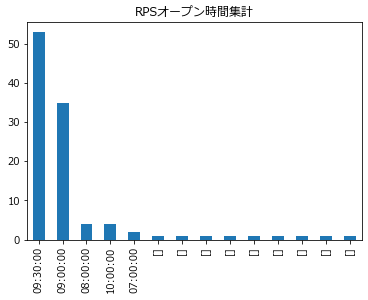

In [53]:
mode_rps_open = df_merge.groupby('shop_name')['rps_opening_time'].agg(pd.Series.mode)
rps_open_counts = mode_rps_open.value_counts()
rps_open_counts.plot(kind='bar')
plt.title("RPSオープン時間集計")
plt.show()

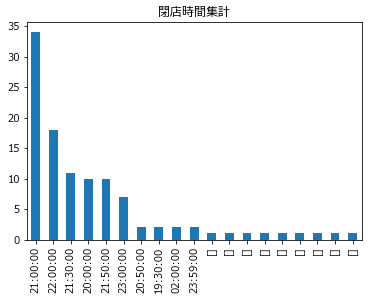

In [54]:
mode_shop_close = df_merge.groupby('shop_name')['store_closing_time'].agg(pd.Series.mode)
shop_close_counts = mode_shop_close.value_counts()
shop_close_counts.plot(kind='bar')
plt.title("閉店時間集計")
plt.show()

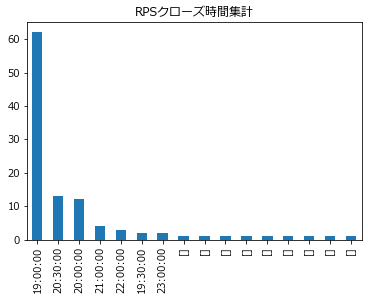

In [56]:
mode_rps_close = df_merge.groupby('shop_name')['rps_closing_time'].agg(pd.Series.mode)
rps_close_counts = mode_rps_close.value_counts()
rps_close_counts.plot(kind='bar')
plt.title("RPSクローズ時間集計")
plt.show()

In [44]:
# timedelta を分数に変換する関数
def timedelta_to_minutes(td):
    return td.total_seconds() / 60

# timedelta 列を分数に変換
df_converted['shop_business_hours_mins'] = df_converted['shop_business_hours'].apply(timedelta_to_minutes)
df_converted['rps_operating_hours_mins'] = df_converted['rps_operating_hours'].apply(timedelta_to_minutes)

In [45]:
def safe_mode(series):
    modes = series.mode()
    if len(modes) > 0:
        return modes.iloc[0]
    else:
        return np.nan

# 各店舗ごとに各列のモードを計算
shop_mode_values = df_converted.groupby('shop_name').agg({'shop_business_hours_mins': safe_mode,
                                                          'rps_operating_hours_mins': safe_mode,
                                                          'rps_shop_hour_ratio': safe_mode})


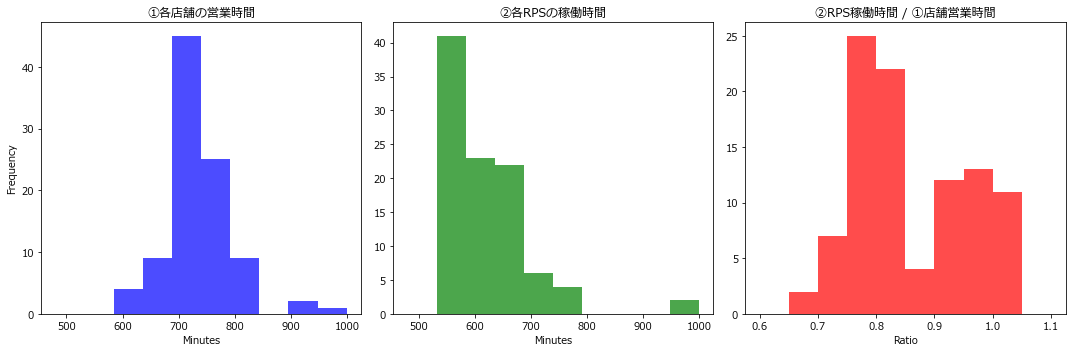

In [61]:
# ヒストグラムを描画
plt.figure(figsize=(15, 5))

# shop_business_hours_mins のヒストグラム
plt.subplot(1, 3, 1)
#plt.hist(shop_mode_values['shop_business_hours_mins'].dropna(), bins=10, color='blue', alpha=0.7)
plt.hist(shop_mode_values['shop_business_hours_mins'].dropna(), bins=10, range=(480,1000), color='blue', alpha=0.7)
plt.title('①各店舗の営業時間')
plt.xlabel('Minutes')
plt.ylabel('Frequency')

# rps_operating_hours_mins のヒストグラム
plt.subplot(1, 3, 2)
plt.hist(shop_mode_values['rps_operating_hours_mins'].dropna(), bins=10, range=(480,1000), color='green', alpha=0.7)
plt.title('②各RPSの稼働時間')
plt.xlabel('Minutes')

# rps_shop_hour_ratio のヒストグラム
plt.subplot(1, 3, 3)
plt.hist(shop_mode_values['rps_shop_hour_ratio'].dropna(), bins=10, range=(0.6,1.1), color='red', alpha=0.7)
plt.title('②RPS稼働時間 / ①店舗営業時間')
plt.xlabel('Ratio')

plt.tight_layout()
plt.show()


In [47]:
# 営業時間がマイナスの行を表示
negative_shop_business_hours = df_converted[df_converted['shop_business_hours_mins'] < 0]
print(len(negative_shop_business_hours))
negative_shop_business_hours

1141


,Unnamed: 0_x,id_x,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude,Unnamed: 0_y,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode,age,age_group,count,shop_business_hours,rps_operating_hours,rps_shop_hour_ratio,shop_business_hours_mins,rps_operating_hours_mins
2863,290781,7230747,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.000,109.000,3,12.000,3.000,2022-08-20 19:42:52,2022-08-21 04:00:33,2022-08-21 04:00:33,15.000,ドン・キホーテ,富谷店,294,2021-09-21 04:21:05,2023-04-08 15:41:29,09:00:00,02:00:00,09:00:00,20:00:00,38.361,140.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,397,-1 days +17:00:00,0 days 11:00:00,-1.571,-420.000,660.000
2862,289453,7212651,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.000,108.000,3,12.000,3.000,2022-08-19 18:50:49,2022-08-20 04:00:39,2022-08-20 04:00:39,15.000,ドン・キホーテ,富谷店,294,2021-09-21 04:21:05,2023-04-08 15:41:29,09:00:00,02:00:00,09:00:00,20:00:00,38.361,140.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,397,-1 days +17:00:00,0 days 11:00:00,-1.571,-420.000,660.000
2860,280679,7062477,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.000,107.000,3,12.000,3.000,2022-08-11 20:31:14,2022-08-12 04:00:30,2022-08-12 04:00:30,15.000,ドン・キホーテ,富谷店,294,2021-09-21 04:21:05,2023-04-08 15:41:29,09:00:00,02:00:00,09:00:00,20:00:00,38.361,140.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,397,-1 days +17:00:00,0 days 11:00:00,-1.571,-420.000,660.000
2859,279407,7044146,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.000,106.000,3,12.000,3.000,2022-08-10 13:11:07,2022-08-11 04:00:35,2022-08-11 04:00:35,15.000,ドン・キホーテ,富谷店,294,2021-09-21 04:21:05,2023-04-08 15:41:29,09:00:00,02:00:00,09:00:00,20:00:00,38.361,140.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,397,-1 days +17:00:00,0 days 11:00:00,-1.571,-420.000,660.000
2858,278391,7027135,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.000,105.000,3,12.000,3.000,2022-08-09 13:30:50,2022-08-10 04:00:35,2022-08-10 04:00:35,15.000,ドン・キホーテ,富谷店,294,2021-09-21 04:21:05,2023-04-08 15:41:29,09:00:00,02:00:00,09:00:00,20:00:00,38.361,140.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,397,-1 days +17:00:00,0 days 11:00:00,-1.571,-420.000,660.000
2856,277172,7008261,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.000,104.000,3,12.000,3.000,2022-08-08 10:38:54,2022-08-09 08:00:16,2022-08-09 08:00:16,15.000,ドン・キホーテ,富谷店,294,2021-09-21 04:21:05,2023-04-08 15:41:29,09:00:00,02:00:00,09:00:00,20:00:00,38.361,140.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,397,-1 days +17:00:00,0 days 11:00:00,-1.571,-420.000,660.000
2854,275213,6978912,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.000,103.000,3,12.000,3.000,2022-08-07 09:08:06,2022-08-08 04:00:46,2022-08-08 04:00:46,15.000,ドン・キホーテ,富谷店,294,2021-09-21 04:21:05,2023-04-08 15:41:29,09:00:00,02:00:00,09:00:00,20:00:00,38.361,140.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,397,-1 days +17:00:00,0 days 11:00:00,-1.571,-420.000,660.000
2852,273733,6955990,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.000,102.000,3,12.000,3.000,2022-08-06 10:04:30,2022-08-07 04:00:38,2022-08-07 04:00:38,15.000,ドン・キホーテ,富谷店,294,2021-09-21 04:21:05,2023-04-08 15:41:29,09:00:00,02:00:00,09:00:00,20:00:00,38.361,140.873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,397,-1 days +17:00:00,0 days 11:00:00,-1.571,-420.000,660.000
2850,272664,6938444,72,8.000,294.000,MEGAドン・キホーテ仙台富谷店,7130066809264269,1.000,1.000,1.000,1.

In [62]:
# 営業時間が900分以上の行を表示
long_shop_business_hours = df_converted[df_converted['shop_business_hours_mins'] >900]
print(len(long_shop_business_hours))
long_shop_business_hours

8


,Unnamed: 0_x,id_x,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude,Unnamed: 0_y,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode,age,age_group,count,shop_business_hours,rps_operating_hours,rps_shop_hour_ratio,shop_business_hours_mins,rps_operating_hours_mins
17617,2042668,16193324,77,13.000,267.000,マックスバリュ野田七光台店,1000001981588188,1.000,0.000,0.000,0.000,0.000,1,0.000,0.000,2023-11-17 10:28:29,2023-11-18 04:00:52,2023-11-18 04:00:52,387.000,マックスバリュ,野田七光台店(登録不可),267,2022-06-16 04:00:32,2023-11-27 12:47:28,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,75191.000,77.000,とみんぐ,378.000,0.000,555.000,209.200,0.000,0.000,男,1985-11-09,9830011.000,38.000,31-40,86,0 days 15:59:00,0 days 16:00:00,1.001,959.000,960.000
17616,2042667,16193321,77,13.000,267.000,マックスバリュ野田七光台店,1000001981588188,1.000,0.000,0.000,0.000,0.000,1,0.000,0.000,2023-11-17 10:25:56,2023-11-18 04:00:51,2023-11-18 04:00:51,387.000,マックスバリュ,野田七光台店(登録不可),267,2022-06-16 04:00:32,2023-11-27 12:47:28,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,75191.000,77.000,とみんぐ,378.000,0.000,555.000,209.200,0.000,0.000,男,1985-11-09,9830011.000,38.000,31-40,86,0 days 15:59:00,0 days 16:00:00,1.001,959.000,960.000
2147861,2130212,16475577,104804,18.000,266.000,マックスバリュ松ヶ崎店,1000001141777704,1.000,1.400,1.400,1.000,0.000,1,1.000,0.000,2023-11-30 15:53:24,2023-12-01 04:00:45,2023-12-01 04:00:45,527.000,マックスバリュ,松ヶ崎店(登録不可),266,2023-11-18 18:43:40,2023-11-27 12:39:58,00:00:00,23:59:00,07:00:00,23:00:00,35.880,139.968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 23:59:00,0 days 16:00:00,0.667,1439.000,960.000
2147863,2130214,16475579,104804,20.000,266.000,マックスバリュ松ヶ崎店,6900175567824729,1.000,1.400,1.400,1.000,0.000,1,1.000,0.000,2023-11-30 15:54:34,2023-12-01 04:00:47,2023-12-01 04:00:47,528.000,マックスバリュ,松ヶ崎店(登録不可),266,2023-11-18 18:45:01,2023-11-27 12:46:47,00:00:00,23:59:00,07:00:00,23:00:00,35.880,139.968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 23:59:00,0 days 16:00:00,0.667,1439.000,960.000
2147864,2138141,16495212,104804,18.000,267.000,マックスバリュ野田七光台店,1000001141777704,1.000,1.100,1.100,1.000,0.000,1,1.000,0.000,2023-12-01 10:06:06,2023-12-02 04:01:10,2023-12-02 04:01:10,529.000,マックスバリュ,野田七光台店(登録不可),267,2023-11-18 18:47:15,2023-11-27 12:39:43,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 15:59:00,0 days 16:00:00,1.001,959.000,960.000
2147862,2130213,16475578,104804,13.000,266.000,マックスバリュ松ヶ崎店,1014008374,1.000,1.400,1.400,1.000,47.000,1,1.000,0.000,2023-11-30 15:53:58,2023-12-01 04:00:46,2023-12-01 04:00:46,386.000,マックスバリュ,松ヶ崎店(登録不可),266,2022-06-16 04:00:32,2023-11-27 12:47:17,00:00:00,23:59:00,07:00:00,23:00:00,35.880,139.968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 23:59:00,0 days 16:00:00,0.667,1439.000,960.000
2147866,2138143,16495214,104804,20.000,267.000,マックスバリュ野田七光台店,6900175567824729,1.000,1.100,1.100,1.000,0.000,1,1.000,0.000,2023-12-01 10:07:04,2023-12-02 04:01:12,2023-12-02 04:01:12,530.000,マックスバリュ,野田七光台店(登録不可),267,2023-11-18 18:48:22,2023-11-27 12:47:00,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 15:59:00,0 days 16:00:00,1.001,959.000,960.000
2147865,2138142,16495213,104804,13.000,267.000,マックスバリュ野田七光台店,1014008374,1.000,1.100,1.100,1.000,48.000,1,1.000,0.000,2023-12-01 10:06:34,2023-12-02 04:01:11,2023-12-02 04:01:11,387.000,マックスバリュ,野田七光台店(登録不可),267,2022-06-16 04:00:32,2023-11-27 12:47:28,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 15:59:00,0 

In [63]:
# RPS稼働が900分以上の行を表示
long_rps_operating_hours = df_converted[df_converted['rps_operating_hours_mins'] >900]
print(len(long_rps_operating_hours))
long_rps_operating_hours

8


,Unnamed: 0_x,id_x,user_id,series_id,shop_id,shop_name,card_id,リサイクル分類ID,amount,amount_kg,point,total_point,status,coin,rank_id,use_date,created_at,updated_at,支店ID,super,shop_name_1,shop_id_1,created_at_1,updated_at_1,store_opening_time,store_closing_time,rps_opening_time,rps_closing_time,store_latitude,store_longitude,Unnamed: 0_y,id_y,nickname,club_coin,recycle_point,total_recycle_amount,recycle_amount_per_year,recycle_amount_after_gold_member,rank_continuation_class,gender,birth_day,zipcode,age,age_group,count,shop_business_hours,rps_operating_hours,rps_shop_hour_ratio,shop_business_hours_mins,rps_operating_hours_mins
17617,2042668,16193324,77,13.000,267.000,マックスバリュ野田七光台店,1000001981588188,1.000,0.000,0.000,0.000,0.000,1,0.000,0.000,2023-11-17 10:28:29,2023-11-18 04:00:52,2023-11-18 04:00:52,387.000,マックスバリュ,野田七光台店(登録不可),267,2022-06-16 04:00:32,2023-11-27 12:47:28,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,75191.000,77.000,とみんぐ,378.000,0.000,555.000,209.200,0.000,0.000,男,1985-11-09,9830011.000,38.000,31-40,86,0 days 15:59:00,0 days 16:00:00,1.001,959.000,960.000
17616,2042667,16193321,77,13.000,267.000,マックスバリュ野田七光台店,1000001981588188,1.000,0.000,0.000,0.000,0.000,1,0.000,0.000,2023-11-17 10:25:56,2023-11-18 04:00:51,2023-11-18 04:00:51,387.000,マックスバリュ,野田七光台店(登録不可),267,2022-06-16 04:00:32,2023-11-27 12:47:28,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,75191.000,77.000,とみんぐ,378.000,0.000,555.000,209.200,0.000,0.000,男,1985-11-09,9830011.000,38.000,31-40,86,0 days 15:59:00,0 days 16:00:00,1.001,959.000,960.000
2147861,2130212,16475577,104804,18.000,266.000,マックスバリュ松ヶ崎店,1000001141777704,1.000,1.400,1.400,1.000,0.000,1,1.000,0.000,2023-11-30 15:53:24,2023-12-01 04:00:45,2023-12-01 04:00:45,527.000,マックスバリュ,松ヶ崎店(登録不可),266,2023-11-18 18:43:40,2023-11-27 12:39:58,00:00:00,23:59:00,07:00:00,23:00:00,35.880,139.968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 23:59:00,0 days 16:00:00,0.667,1439.000,960.000
2147863,2130214,16475579,104804,20.000,266.000,マックスバリュ松ヶ崎店,6900175567824729,1.000,1.400,1.400,1.000,0.000,1,1.000,0.000,2023-11-30 15:54:34,2023-12-01 04:00:47,2023-12-01 04:00:47,528.000,マックスバリュ,松ヶ崎店(登録不可),266,2023-11-18 18:45:01,2023-11-27 12:46:47,00:00:00,23:59:00,07:00:00,23:00:00,35.880,139.968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 23:59:00,0 days 16:00:00,0.667,1439.000,960.000
2147864,2138141,16495212,104804,18.000,267.000,マックスバリュ野田七光台店,1000001141777704,1.000,1.100,1.100,1.000,0.000,1,1.000,0.000,2023-12-01 10:06:06,2023-12-02 04:01:10,2023-12-02 04:01:10,529.000,マックスバリュ,野田七光台店(登録不可),267,2023-11-18 18:47:15,2023-11-27 12:39:43,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 15:59:00,0 days 16:00:00,1.001,959.000,960.000
2147862,2130213,16475578,104804,13.000,266.000,マックスバリュ松ヶ崎店,1014008374,1.000,1.400,1.400,1.000,47.000,1,1.000,0.000,2023-11-30 15:53:58,2023-12-01 04:00:46,2023-12-01 04:00:46,386.000,マックスバリュ,松ヶ崎店(登録不可),266,2022-06-16 04:00:32,2023-11-27 12:47:17,00:00:00,23:59:00,07:00:00,23:00:00,35.880,139.968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 23:59:00,0 days 16:00:00,0.667,1439.000,960.000
2147866,2138143,16495214,104804,20.000,267.000,マックスバリュ野田七光台店,6900175567824729,1.000,1.100,1.100,1.000,0.000,1,1.000,0.000,2023-12-01 10:07:04,2023-12-02 04:01:12,2023-12-02 04:01:12,530.000,マックスバリュ,野田七光台店(登録不可),267,2023-11-18 18:48:22,2023-11-27 12:47:00,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 15:59:00,0 days 16:00:00,1.001,959.000,960.000
2147865,2138142,16495213,104804,13.000,267.000,マックスバリュ野田七光台店,1014008374,1.000,1.100,1.100,1.000,48.000,1,1.000,0.000,2023-12-01 10:06:34,2023-12-02 04:01:11,2023-12-02 04:01:11,387.000,マックスバリュ,野田七光台店(登録不可),267,2022-06-16 04:00:32,2023-11-27 12:47:28,08:00:00,23:59:00,07:00:00,23:00:00,35.981,139.853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,6,0 days 15:59:00,0 